# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
boston = pd.read_csv('boston_house_prices.csv', header=[1])
boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [ ]:
X = boston.drop(columns='MEDV')
y = boston['MEDV']

In [ ]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) =
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] =
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.334612821243546

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка.

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$.

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$.

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [ ]:
def compute_bias_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """
    squared_error = 0.0
    predictions = np.zeros_like(y, dtype=float)
    squared_predictions = np.zeros_like(y, dtype=float)
    cnt = np.zeros_like(y, dtype=int)

    for _ in range(num_runs):
        bootstrap = np.random.choice(np.arange(X.shape[0]), X.shape[0])
        X_train = X.iloc[bootstrap]
        y_train = y[bootstrap]

        out_of_bag = ~np.in1d(np.arange(X.shape[0]), np.unique(bootstrap))

        X_test = X[out_of_bag]
        y_test = y[out_of_bag]


        regressor.fit(X_train, y_train)
        y_pred = regressor.predict(X_test)

        squared_error += np.sum((y_test - y_pred) ** 2)

        predictions[out_of_bag] += y_pred
        squared_predictions[out_of_bag] += y_pred**2
        cnt[out_of_bag] += 1



    mean_pred = predictions / cnt

    bias = np.mean((mean_pred - y)**2)
    var = np.mean(squared_predictions / cnt -  mean_pred ** 2)
    return bias, var, squared_error / np.sum(cnt)


__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
linear_reg = LinearRegression()
regressors = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
names = ['Linear', 'DecisionTree', 'RandomForest']


for name, regressor in zip(names, regressors):
  bias, variance, error = compute_bias_variance(regressor, X, y)
  print(f'{name} regressor: bias={bias}, variance={variance}, error = {error}')

Linear regressor: bias=23.768917757546, variance=0.9358957312177429, error = 24.567402837705824
DecisionTree regressor: bias=10.390449555231609, variance=13.061496411368163, error = 23.589459439111586
RandomForest regressor: bias=10.720949852479503, variance=2.280750123295961, error = 12.937283778715587


__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Из лекций знаем, что для линейных моделей характерно большое смещение, так как они не очень сложные и не могут описать любую зависимость, но с другой стороны они не подвержены разбросу, то есть не сильно зависят от изменения обучающей выборки, что и подтверждается на практике.

Также из лекций знаем, что решающие деревья имеют низкое смещение, так как могут подогнаться под обучающую выборку очень хорошо, но из этого вырастает разброс, так как модель становится более чувствительной к изменению выборки. Эти теоретические выкладки также подтверждаются нашими опытами.

Про случайный лес знаем, что смещение такое же, как и у базовой модели, то есть как и у решающего дерева, а разброс уменьшается с увелечением количества базовых моделей до какого-то момента, далее останавливается. Эти замечания с лекций также согласуются с нашими результатами, так как смещение оказалось равным смещению дерева, а разброс уменьшился очень сильно.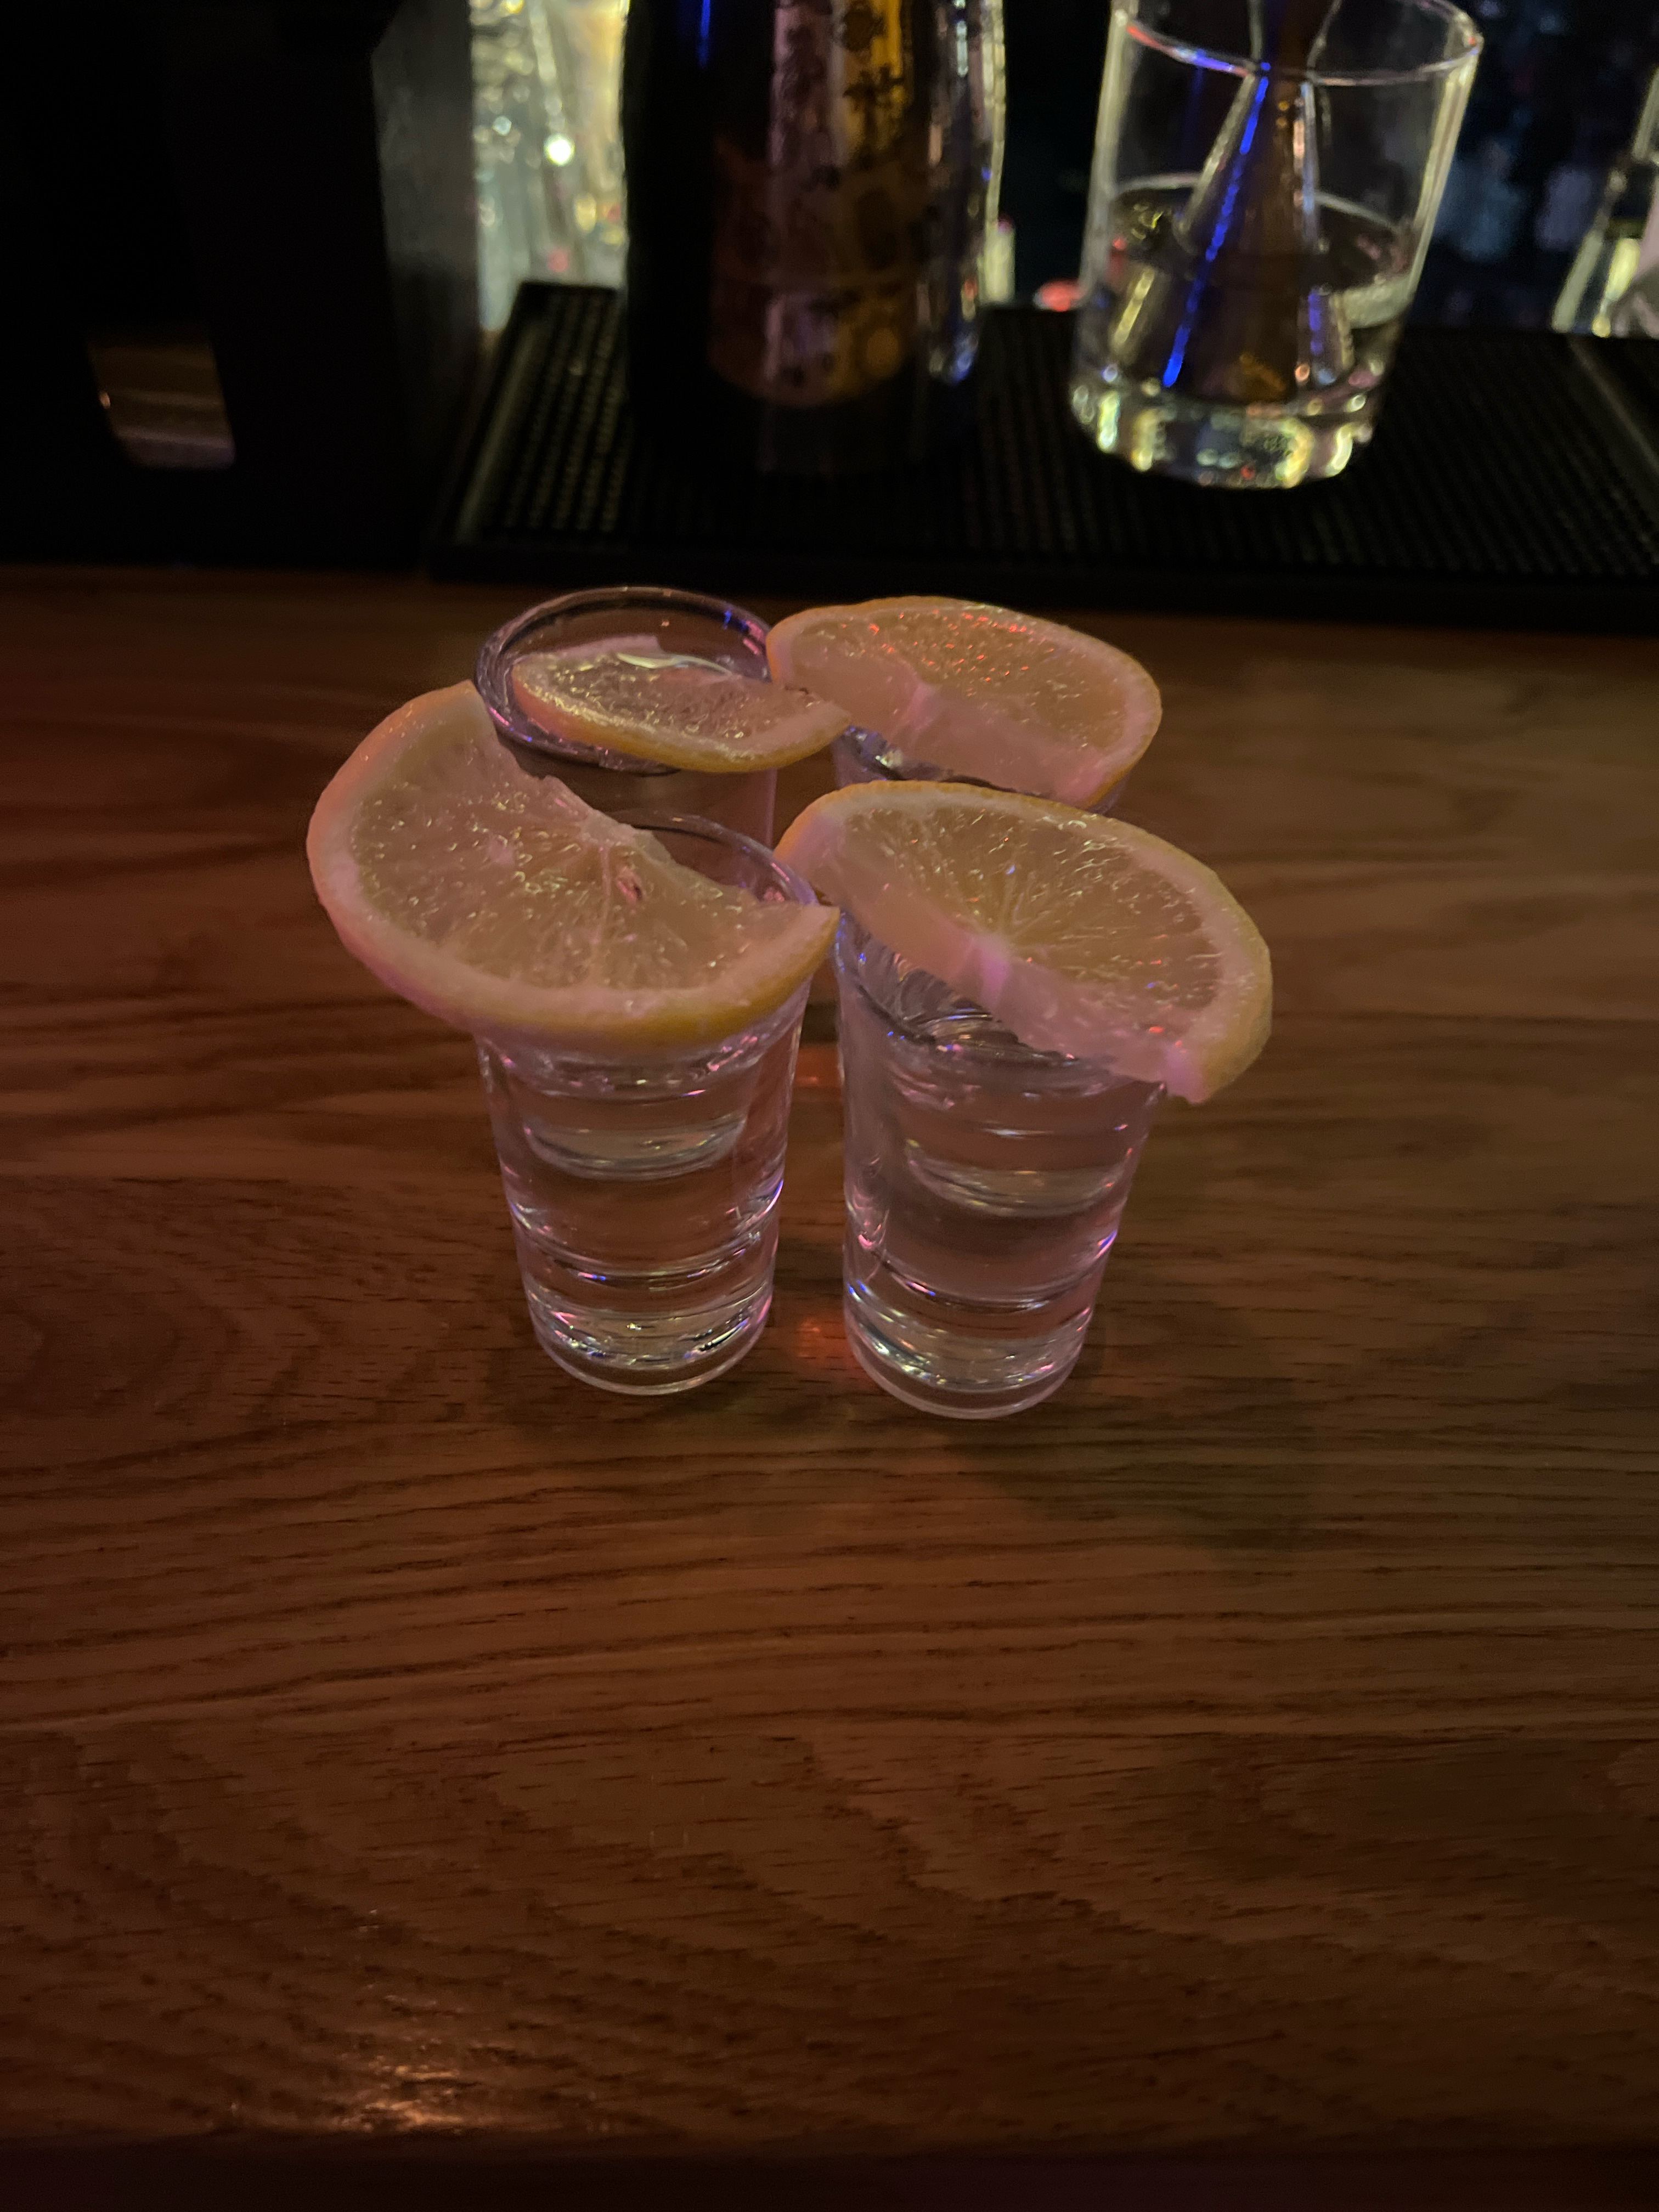

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [ ]:
from sklearn.ensemble import BaggingRegressor

for name, regressor in zip(names, regressors):
  bias, variance, error = compute_bias_variance(BaggingRegressor(regressor), X, y)
  print(f'{name} regressor with bagging: bias={bias}, variance={variance}, error = {error}')

Linear regressor with bagging: bias=23.73372951349386, variance=1.039950569005388, error = 24.91044812070995
DecisionTree regressor with bagging: bias=10.625010803885175, variance=3.396117372397219, error = 13.873894187342218
RandomForest regressor with bagging: bias=11.686934194618425, variance=1.400671116325033, error = 13.080546598008905


То что мы сделали, в случае с решающим дереовм, по сути сделали неоптимальный случайный лес, поэтому результаты получились сравнимымы с RF, но чуть хуже. Линейная модель не почувствовала беггинга и выдала тот же результат, который был и до этого, потому что этот подход стремится уменьшить разброс новой модели относительно базовых, но у нашей базовой модели и так всё было хорошо. В случайного леса мы против сделали обучение намного дольше по сути не делая ничего нового. С лекций знаем, что в теории, предполгая некоррелированность базовых моделей, можно добиться уменьшения разброса в n раз, где n количество базовых моделей

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [ ]:
import seaborn as sns

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=''):
    test_idx = np.random.choice(len(X), size=num_test_objects, replace=False)
    train_idx = np.setdiff1d(np.arange(len(X)), test_idx)

    X_test, y_test = X.iloc[test_idx], y[test_idx]
    X_train, y_train = X.iloc[train_idx], y[train_idx]

    preds = np.zeros((num_test_objects, num_runs))

    for j in range(num_runs):
        idx = np.random.choice(len(X_train), size=len(X_train), replace=True)
        cur_X  = X_train.iloc[idx]
        cur_y = y_train.iloc[idx]
        regressor.fit(cur_X, cur_y)
        preds[:, j] = regressor.predict(X_test)

    columns = list(range(num_test_objects))
    new_preds = pd.DataFrame(preds.T, columns=columns).stack().reset_index()
    new_preds.columns = ['Run', 'Test Object', 'Prediction']

    sns.scatterplot(data=new_preds, x='Test Object', y='Prediction', hue='Run').set(xlabel='Test Objects', ylabel='Predictions', title=title)
    sns.scatterplot(x=range(num_test_objects), y=y_test, color='black', marker='o', s=70)

    plt.legend().remove()


__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

<ipython-input-56-aced6b94b306>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, i + 1, sharey=plt.gca())


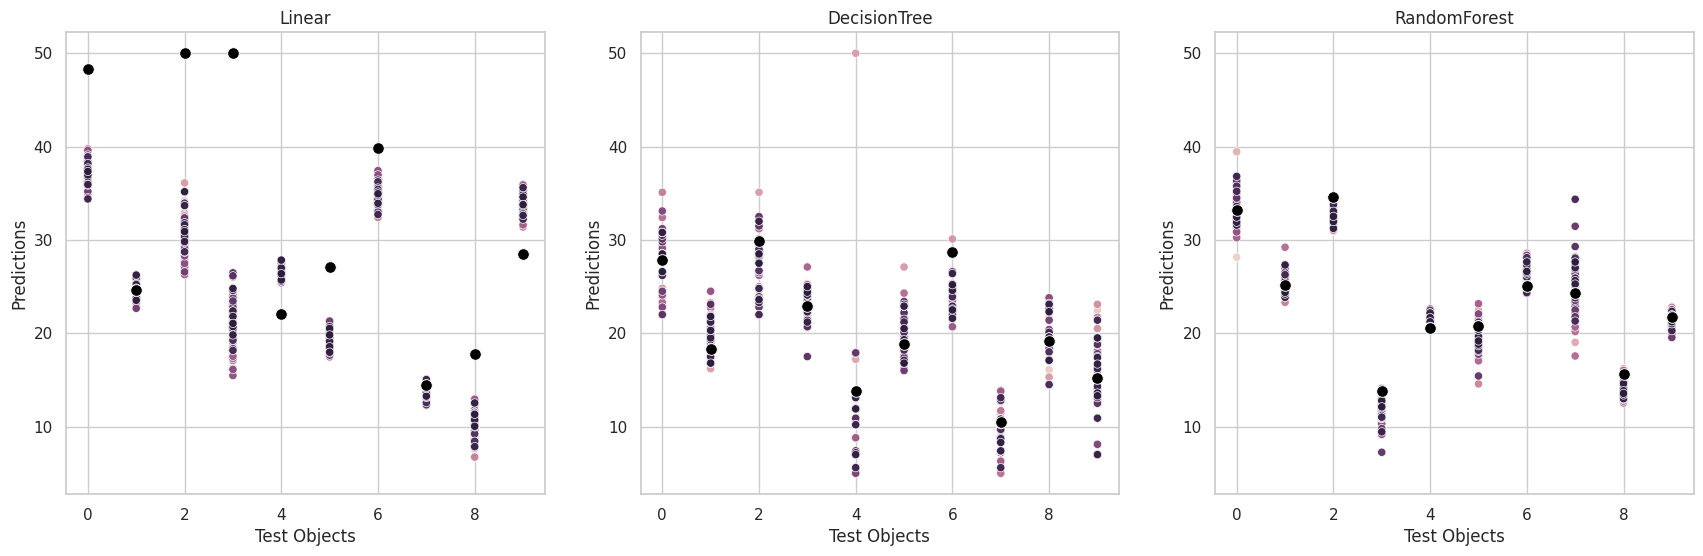

In [ ]:
plt.figure(figsize=(21, 6))
for i in range(3):
  name = names[i]
  regressor = regressors[i]
  plt.subplot(1, 3, i + 1, sharey=plt.gca())
  plot_predictions(regressor, X, y, title=name)

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма.

__Your answer here:__

Линейная модель часто ошибается, что сигнализирует о большом смещении, о чем мы уже говорили, у деревьев большой разброс, это также уже отмечалось, а случайный лес и угадывает хорошо, и разброс наименьший

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [ ]:
biases = []
variances = []

plt.figure(figsize=(21, 6))
biases = np.zeros(10)
variances = np.zeros(10)

for max_depth in range(1, 11):
    tree = DecisionTreeRegressor(max_depth=max_depth)
    biases[max_depth - 1], variances[max_depth - 1], _ = compute_bias_variance(tree, X, y)

[Text(0.5, 1.0, 'Dependence of variance on max depth'),
 Text(0.5, 0, 'max_depth'),
 Text(0, 0.5, 'variance')]

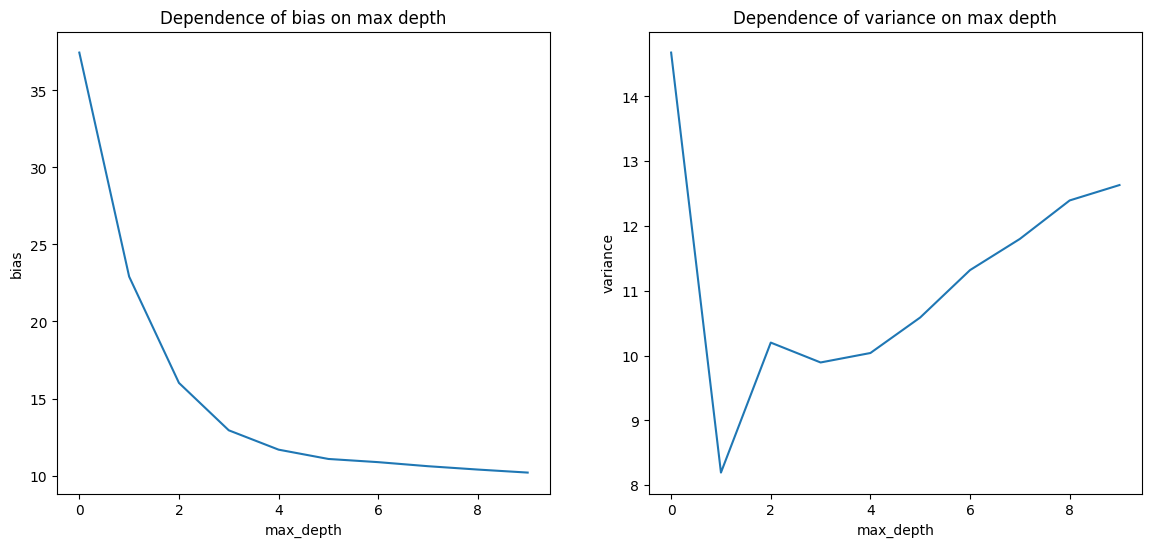

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(biases).set(title='Dependence of bias on max depth', xlabel='max_depth', ylabel='bias')
plt.subplot(1, 2, 2)
sns.lineplot(variances).set(title='Dependence of variance on max depth', xlabel='max_depth', ylabel='variance')

In [ ]:
biases = []
variances = []

biases = np.zeros(X.shape[1] - 1)
variances = np.zeros(X.shape[1] - 1)

for max_features in range(1, X.shape[1]):
    tree = DecisionTreeRegressor(max_features=max_features)
    biases[max_features - 1], variances[max_features - 1], _ = compute_bias_variance(tree, X, y)

<Figure size 2100x600 with 0 Axes>

[Text(0.5, 1.0, 'Dependence of variance on max features'),
 Text(0.5, 0, 'max features'),
 Text(0, 0.5, 'variance')]

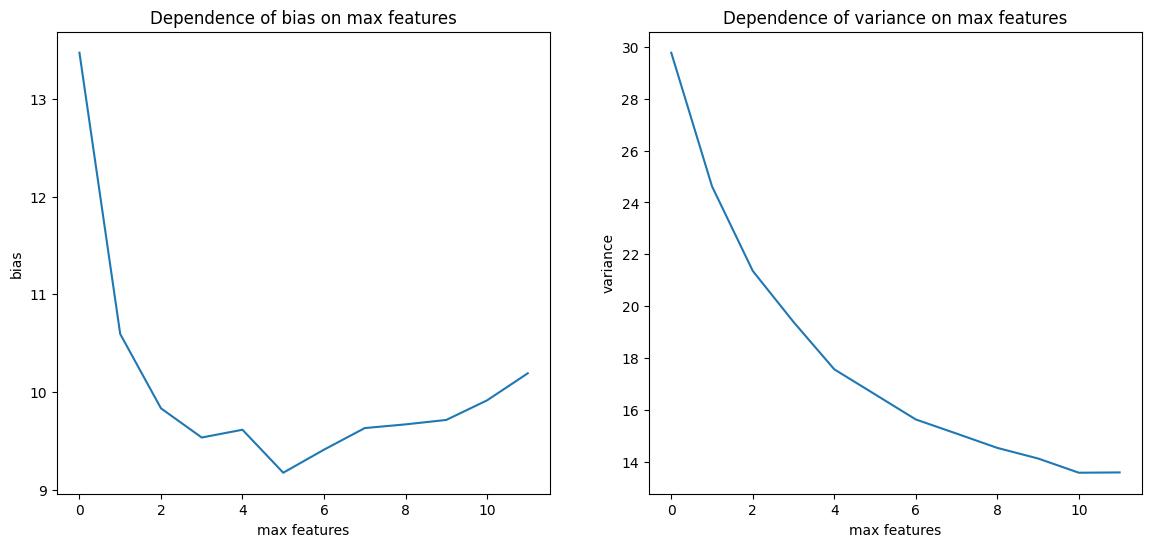

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(biases).set(title='Dependence of bias on max features', xlabel='max features', ylabel='bias')
plt.subplot(1, 2, 2)
sns.lineplot(variances).set(title='Dependence of variance on max features', xlabel='max features', ylabel='variance')

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [ ]:
biases = []
variances = []

biases = np.zeros(10)
variances = np.zeros(10)

n_estimatorss = 2**np.arange(1, 10)
for i in range(9):
    n_estimators = n_estimatorss[i]
    forest = RandomForestRegressor(n_estimators=n_estimators)
    biases[i], variances[i], _ = compute_bias_variance(forest, X, y)

In [ ]:
print(biases)
print(variances)

[10.66448248 10.4883315  10.6184878  10.69851964 10.62101572 10.6727559
 10.51882252 10.59263593 10.69175226  0.        ]
[8.61185866 5.22744983 3.75245398 2.91774377 2.48705393 2.3520992
 2.18880489 2.20991993 2.11980685 0.        ]


[Text(0.5, 1.0, 'Dependence of variance on n_estimators'),
 Text(0.5, 0, 'n_estimators'),
 Text(0, 0.5, 'variance')]

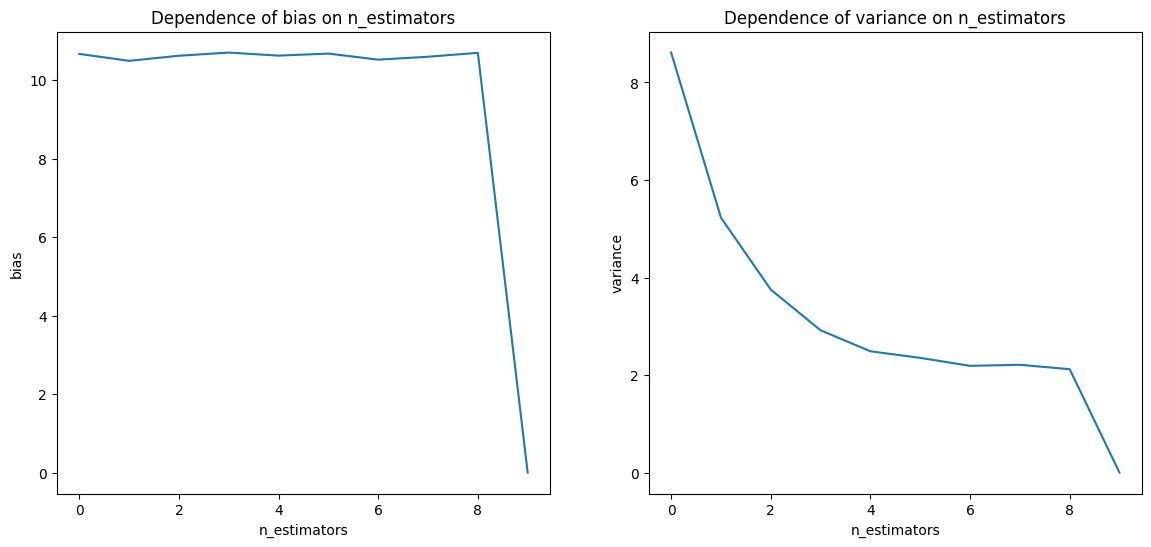

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(biases).set(title='Dependence of bias on n_estimators', xlabel='n_estimators', ylabel='bias')
plt.subplot(1, 2, 2)
sns.lineplot(variances).set(title='Dependence of variance on n_estimators', xlabel='n_estimators', ylabel='variance')

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
biases = []
variances = []

biases = np.zeros(9)
variances = np.zeros(9)

n_estimatorss = 2**np.arange(1, 10)
for i in range(9):
    print(i)
    n_estimators = n_estimatorss[i]
    forest = GradientBoostingRegressor(n_estimators=n_estimators)
    biases[i], variances[i], _ = compute_bias_variance(forest, X, y)

0
1
2
3
4
5
6
7
8


[Text(0.5, 1.0, 'Dependence of variance on n_estimators'),
 Text(0.5, 0, 'n_estimators'),
 Text(0, 0.5, 'variance'),
 None]

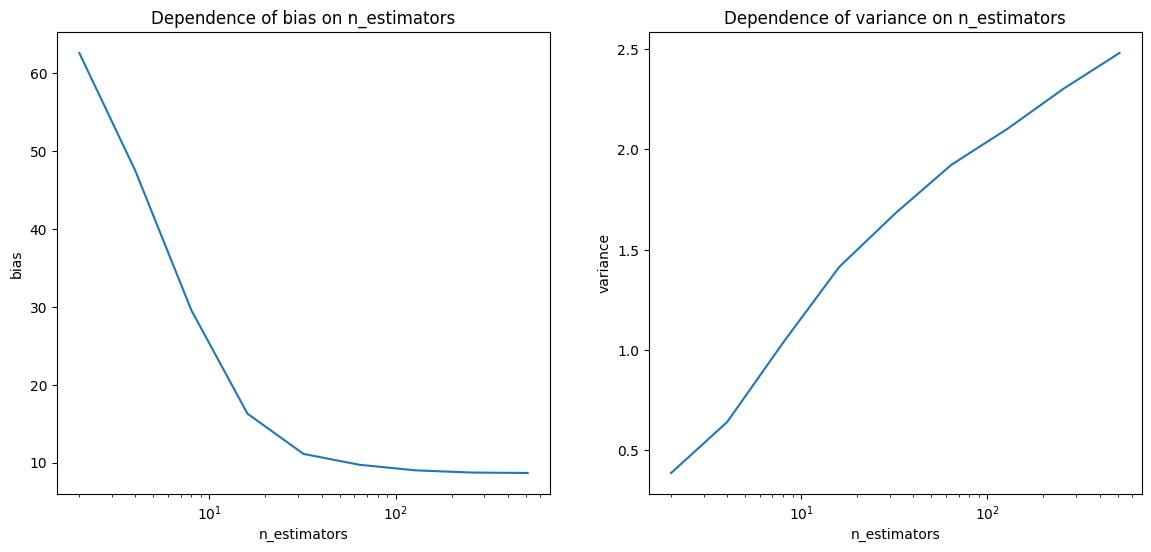

In [28]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x=n_estimatorss, y=biases).set(title='Dependence of bias on n_estimators', xlabel='n_estimators', ylabel='bias', xscale='log')
plt.subplot(1, 2, 2)
sns.lineplot(x=n_estimatorss, y=variances).set(title='Dependence of variance on n_estimators', xlabel='n_estimators', ylabel='variance', xscale='log')

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

С увеличением глубины деревьев смещение уменьшается, что соответствует лекциям, так как увеличивается способность деревьев к точному предсказанию на обучающей выборке, но при этом возникает переобучение, что приводит к увеличению разброса.

С увеличением числа признаков в дереве смещение сначала снижается, а затем выходит на постоянный уровень, в то время как разброс равномерно уменьшается. Это связано с тем, что при добавлении большего числа признаков дерево становится менее склонным к переобучению, что уменьшает эффект смещения.

В случае случайного леса с добавлением новых моделей разброс уменьшается, что подтверждает теорию, при этом смещение колеблется вокруг значения, представляющего базовую модель.

Для градиентного бустинга с увеличением числа моделей смещение снижается, так как каждая новая модель пытается уменьшить ошибку, но возникает переобучение, что проявляется ростом разброса.

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__
Оно там выше вставилось ахахха